In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, train_test_split
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error
import optuna
from tqdm import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline

In [19]:
base_path = 'E:/python/data/训练赛/TabularPlaygroundSeriesJan/tabular-playground-series-jan-2021/'
train = pd.read_csv(base_path+'train.csv',index_col='id')
test = pd.read_csv(base_path+'test.csv', index_col='id')
target = train['target']


In [3]:
features = [f for f in train.columns.tolist() if f not in ['target','id']]
data = pd.concat([train[features],test])

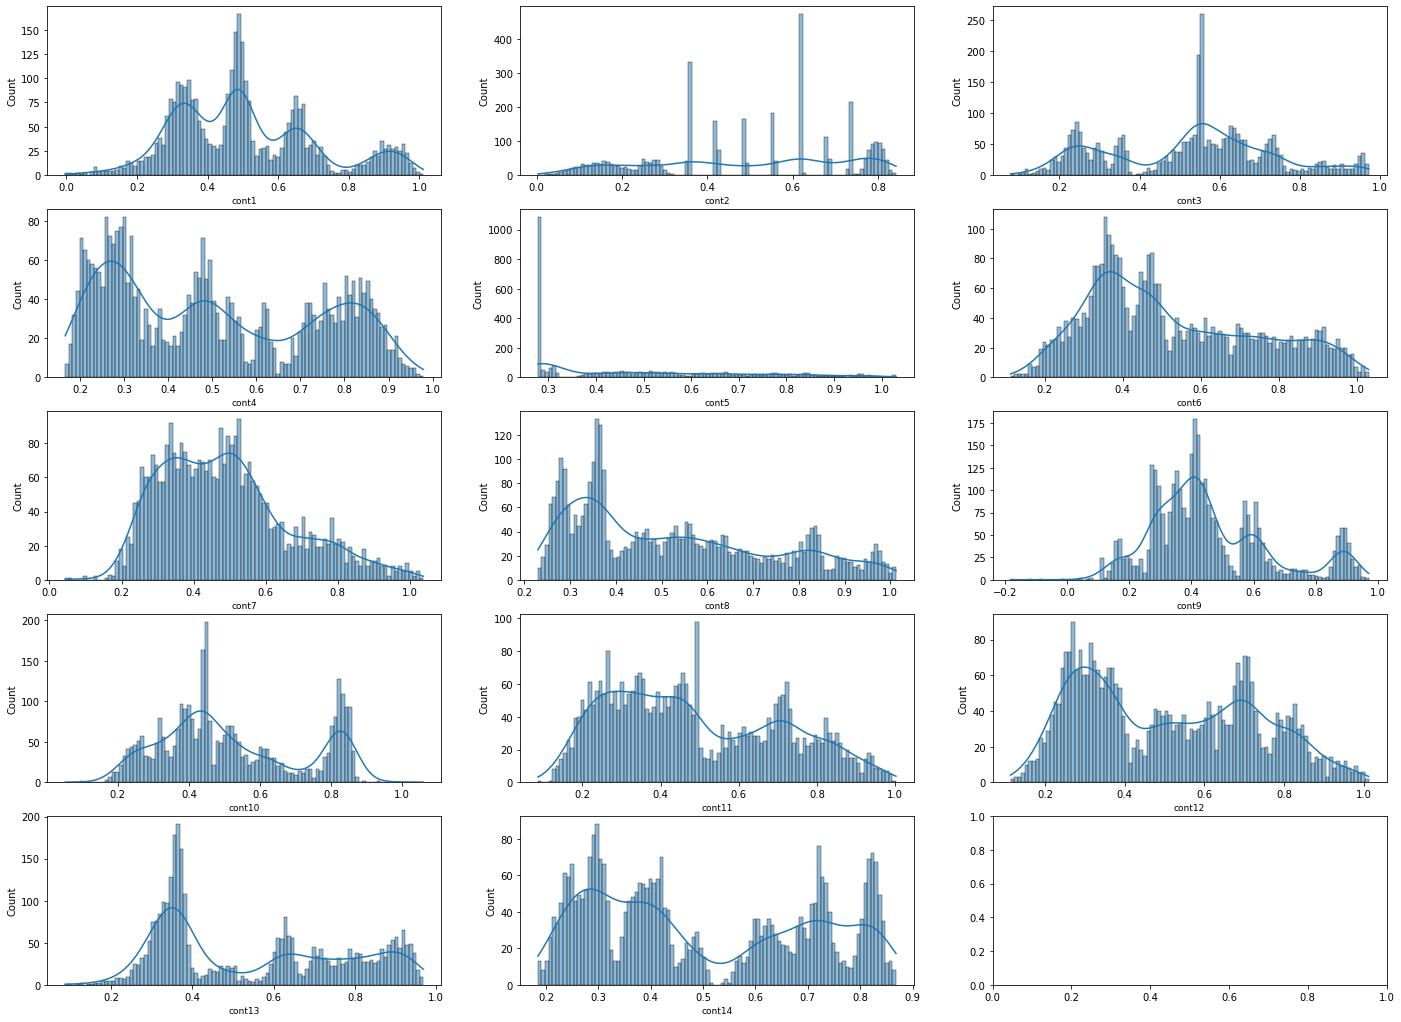

In [4]:
plt.subplots(5,3,figsize=(24,18))
for i,feature in enumerate(features):
    plt.subplot(5,3,i+1)
    sns.histplot(data[feature][::150],kde=True,bins=100)
    plt.xlabel(feature,fontsize=9)
#     plt.xticks(np.arange(data[feature].min(),data[feature].max(),0.01))
plt.show()

In [5]:
plt.figure(figsize=(60,6))
feature = 'cont'+str(14)
sns.histplot(data[feature][::150],kde=True,bins=100)
plt.xticks(np.arange(data[feature].min(),data[feature].max(),0.01))
plt.show()

In [4]:
inits = [[0.338,0.488,0.568,0.648,0.928],
    [0.1586,0.2686,0.3586,0.4186,0.4886,0.551,0.6186,0.6786,0.7386,0.7986],
    [0.241,0.3,0.355,0.557,0.631,0.734,0.855,0.955],
    [0.205,0.28,0.3828,0.48,0.5428,0.62,0.755,0.8128,0.85],
    [0.28,0.305,0.4164,0.4564,0.5264,0.5464,0.6464,0.7664,0.9564],
    [0.36,0.47,0.54,0.57,0.61,0.696,0.76,0.82,0.90,0.95,1.016],
    [0.052,0.1,0.125,0.17,0.195,0.34,0.42,0.5,0.57,0.7,0.9,0.99],
    [0.28,0.36,0.45,0.54,0.62,0.68,0.83],
    [0.17,0.28,0.355,0.41,0.595,0.76,0.89],
    [0.27,0.32,0.39,0.445,0.52,0.61,0.73,0.82,0.99],
    [0.2589,0.339,0.4589,0.6089,0.7189,0.819,0.93],
    [0.298,0.5086,0.7086,0.82,0.95],
    [0.365,0.49,0.63,0.72,0.8,0.92],
    [0.244,0.295,0.4,0.49,0.61,0.72,0.824]]
gmms = []
for feature, init in zip(features,inits):
    X_ = np.array(data[feature].tolist()).reshape(-1,1)
    means_init = np.array(init)[:,None]
    gmm = GaussianMixture(n_components=len(init),means_init=means_init,random_state=0).fit(X_)
    gmms.append(gmm)
    pred = gmm.predict(X_)
    data[f'{feature}_gmm'] = pred

In [5]:
X_ = data.iloc[:len(train)]
X_['target'] = target

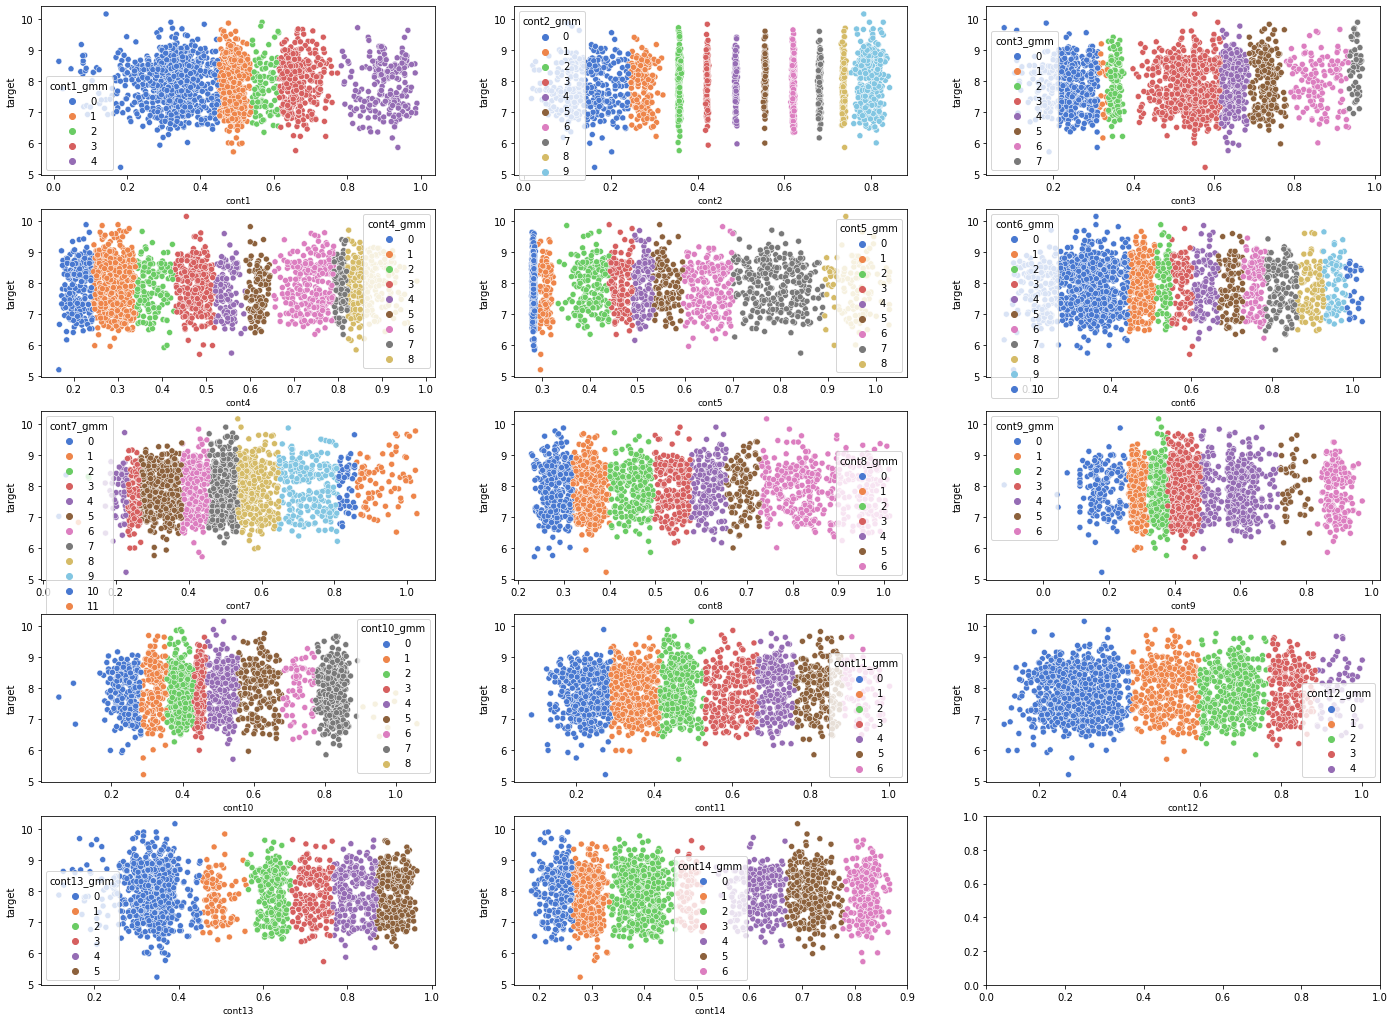

In [8]:
plt.subplots(5,3,figsize=(24,18))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    sns.scatterplot(x=feature,y='target',data = X_[::150] ,hue=f'{feature}_gmm', palette='muted')
    plt.xlabel(feature,fontsize=9)
plt.show()

In [9]:
plt.subplots(5,3,figsize=(24,18))
for i, feature in enumerate(features):
    plt.subplot(5,3,i+1)
    sns.histplot(x=feature,data=data[::150],kde=True,bins=200,hue=f'{feature}_gmm',palette='muted')
    plt.xlabel(feature,fontsize=9)
plt.show()

In [6]:
for feature in features:
    mu = data.groupby(f'{feature}_gmm')[feature].transform('mean')
    sigma = data.groupby(f'{feature}_gmm')[feature].transform('std')
    data[f'{feature}_gmm_dev'] = data[feature] - mu / sigma
# data

In [ ]:
train_feature = [f for f in data.columns.tolist() if f not in ['id', 'target']]
train_data = data.iloc[:len(train)][train_feature]
def objective(trial, data=train_data, target = target):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2, random_state=4142)
#     param = {
#         'metric': 'rmse', 
#         'random_state': 41,
#         'n_estimators': 20000,
#         'learning_rate': 0.01,
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 100.),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.01, 1.0),
#         'subsample': trial.suggest_categorical('subsample', [0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]),
#         'subsample_freq': trial.suggest_int('subsample_freq', 1, 20),
#         'max_depth': trial.suggest_categorical('max_depth', [-1,30,100,300]),
#         'num_leaves' : trial.suggest_int('num_leaves', 2, 500),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
#         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10),
#         'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)
#     }
    param = {
            'metric': 'rmse', 
            'random_state': 41,
            'n_estimators': 20000,
            'learning_rate': 0.01,
            'reg_alpha': 10,
            'reg_lambda': 1,
            'colsample_bytree': 1,
            'subsample': 0.5,
            'subsample_freq': 1,
            'max_depth': 30,
            'num_leaves' : 2,
            'min_child_samples': 1,
            'min_child_weight': 0.1,
            'cat_smooth' : 1
        }
    model = LGBMRegressor(**param)
    model.fit(train_x, train_y,eval_set = [(test_x,test_y)],early_stopping_rounds=200, verbose=500)
    preds = model.predict(test_x)
    rmse = mean_squared_error(test_y, preds,squared=False)
    return rmse
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=1)
print(f'=======================Best trial:{study.best_params}========================')
# study.trials_dataframe()
# optuna.visualization.plot_param_importances(study)
# optuna.visualization.plot_parallel_coordinate(study)
# optuna.visualization.plot_contour(study, params=['num_leaves', 'max_depth', 'subsample', 'min_child_samples', 'colsample_bytree'])
# optuna.visualization.plot_optimization_history(study)

[I 2021-03-15 19:11:49,010] A new study created in memory with name: no-name-bf49c50f-b12a-4ef1-9713-c7326ac2c77b


Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 0.721497
[1000]	valid_0's rmse: 0.718489
[1500]	valid_0's rmse: 0.716671
[2000]	valid_0's rmse: 0.715363
[2500]	valid_0's rmse: 0.714328
[3000]	valid_0's rmse: 0.713485
[3500]	valid_0's rmse: 0.712814
[4000]	valid_0's rmse: 0.712249
[4500]	valid_0's rmse: 0.71177
[5000]	valid_0's rmse: 0.711339
[5500]	valid_0's rmse: 0.710969
[6000]	valid_0's rmse: 0.710632
[6500]	valid_0's rmse: 0.710325
[7000]	valid_0's rmse: 0.710054
[7500]	valid_0's rmse: 0.709815
[8000]	valid_0's rmse: 0.709579
[8500]	valid_0's rmse: 0.70938
[9000]	valid_0's rmse: 0.709191
[9500]	valid_0's rmse: 0.709021
[10000]	valid_0's rmse: 0.708855
[10500]	valid_0's rmse: 0.708711
[11000]	valid_0's rmse: 0.708583
[11500]	valid_0's rmse: 0.708459
[12000]	valid_0's rmse: 0.708345
[12500]	valid_0's rmse: 0.708225
[13000]	valid_0's rmse: 0.708109
[13500]	valid_0's rmse: 0.70801
[14000]	valid_0's rmse: 0.707916
[14500]	valid_0's rmse: 0.707831
[150

[I 2021-03-15 19:15:48,332] Trial 0 finished with value: 0.7070969077460896 and parameters: {}. Best is trial 0 with value: 0.7070969077460896.


Training until validation scores don't improve for 200 rounds
[500]	valid_0's rmse: 0.721497
[1000]	valid_0's rmse: 0.718489
[1500]	valid_0's rmse: 0.716671
[2000]	valid_0's rmse: 0.715363
[2500]	valid_0's rmse: 0.714328
[3000]	valid_0's rmse: 0.713485
[3500]	valid_0's rmse: 0.712814
[4000]	valid_0's rmse: 0.712249
[4500]	valid_0's rmse: 0.71177
[5000]	valid_0's rmse: 0.711339
[5500]	valid_0's rmse: 0.710969
[6000]	valid_0's rmse: 0.710632
[6500]	valid_0's rmse: 0.710325


In [18]:
train_feature = [f for f in data.columns.tolist() if f not in ['id', 'target']]
train_data = data.iloc[:len(train)][train_feature]
NUM_FOLDS = 10
seed_list = [0,1,2]

test_pred = np.zeros(len(test))
val_pred = np.zeros(len(train))

for seed in tqdm(seed_list):
    tmp_test_pred = np.zeros(len(test))
    tmp_val_pred = np.zeros(len(train))
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=seed)
    for f, (train_idx, val_idx) in tqdm(enumerate(kf.split(train[features], target))):
        print("*" * 20)
        print(f"Seed-#{seed};  Fold-#{f}")        
        train_x, val_x = train_data.iloc[train_idx][train_feature], train_data.iloc[val_idx][train_feature]
        train_y, val_y = target.iloc[train_idx], target.iloc[val_idx]
        
        model = LGBMRegressor(metric = 'rmse',
                              random_state=seed, 
                              learning_rate = 0.01,
                              n_estimators = 20000,
                              reg_alpha: 1.505147325240921, 
                              reg_lambda: 0.00398365245623873, 
                              colsample_bytree: 0.3806686062044889, 
                              subsample: 0.8, 
                              subsample_freq: 5, 
                              max_depth: 300, 
                              num_leaves: 165, 
                              min_child_samples: 74, 
                              min_child_weight: 1.0761727519005055, 
                              cat_smooth: 49
                )
        model.fit(train_x,train_y,eval_set=[(val_x,val_y)],early_stopping_rounds=100,verbose=500)

        temp_oof = model.predict(val_x)
        temp_test = model.predict(data.iloc[len(train):][train_feature])

        tmp_test_pred += temp_test
        tmp_val_pred[val_idx] = temp_oof
        print(mean_squared_error(temp_oof, val_y, squared=False))

    print("*" * 20)
    print(f"Seed-#{seed}\n{mean_squared_error(tmp_val_pred, target, squared=False)}")
    val_pred += tmp_val_pred
    test_pred += tmp_test_pred / NUM_FOLDS

val_pred /= len(seed_list)
test_pred /= len(seed_list)
print("*" * 20)
print(mean_squared_error(val_pred, target, squared=False))

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]

********************
Seed-#0;  Fold-#0
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.704979
[1000]	valid_0's rmse: 0.700981
[1500]	valid_0's rmse: 0.700005
[2000]	valid_0's rmse: 0.699421
[2500]	valid_0's rmse: 0.699077
[3000]	valid_0's rmse: 0.698749
[3500]	valid_0's rmse: 0.698585
Early stopping, best iteration is:
[3578]	valid_0's rmse: 0.698542



1it [01:38, 98.37s/it]

0.6985422435341193
********************
Seed-#0;  Fold-#1
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.706065
[1000]	valid_0's rmse: 0.701827
[1500]	valid_0's rmse: 0.70083
[2000]	valid_0's rmse: 0.70021
[2500]	valid_0's rmse: 0.699766
[3000]	valid_0's rmse: 0.699428
[3500]	valid_0's rmse: 0.699178
[4000]	valid_0's rmse: 0.699053
[4500]	valid_0's rmse: 0.698902
[5000]	valid_0's rmse: 0.698759
[5500]	valid_0's rmse: 0.698648
[6000]	valid_0's rmse: 0.698579
Early stopping, best iteration is:
[5951]	valid_0's rmse: 0.698568



2it [04:19, 117.14s/it]

0.6985678071120509
********************
Seed-#0;  Fold-#2
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.7074
[1000]	valid_0's rmse: 0.70354
[1500]	valid_0's rmse: 0.702442
[2000]	valid_0's rmse: 0.70192
[2500]	valid_0's rmse: 0.701471
[3000]	valid_0's rmse: 0.701116
[3500]	valid_0's rmse: 0.700879
Early stopping, best iteration is:
[3835]	valid_0's rmse: 0.700827



3it [06:23, 119.15s/it]

0.7008273314040082
********************
Seed-#0;  Fold-#3
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.703679
[1000]	valid_0's rmse: 0.699544
[1500]	valid_0's rmse: 0.698321
[2000]	valid_0's rmse: 0.697678
[2500]	valid_0's rmse: 0.697146
[3000]	valid_0's rmse: 0.696739
Early stopping, best iteration is:
[3212]	valid_0's rmse: 0.69663



4it [07:59, 112.21s/it]

0.6966298472749534
********************
Seed-#0;  Fold-#4
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.708259
[1000]	valid_0's rmse: 0.704215
[1500]	valid_0's rmse: 0.702956
[2000]	valid_0's rmse: 0.702235
[2500]	valid_0's rmse: 0.701732
[3000]	valid_0's rmse: 0.701321
[3500]	valid_0's rmse: 0.70108
[4000]	valid_0's rmse: 0.700933
[4500]	valid_0's rmse: 0.700829
[5000]	valid_0's rmse: 0.700744
Early stopping, best iteration is:
[4990]	valid_0's rmse: 0.700735



5it [10:46, 128.89s/it]

0.7007350607067998
********************
Seed-#0;  Fold-#5
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.705849
[1000]	valid_0's rmse: 0.701432
[1500]	valid_0's rmse: 0.700147
[2000]	valid_0's rmse: 0.699389
[2500]	valid_0's rmse: 0.698859
[3000]	valid_0's rmse: 0.698543
[3500]	valid_0's rmse: 0.698316
[4000]	valid_0's rmse: 0.698202
[4500]	valid_0's rmse: 0.698058
[5000]	valid_0's rmse: 0.698003
Early stopping, best iteration is:
[5123]	valid_0's rmse: 0.697981



6it [13:19, 135.95s/it]

0.6979814287065166
********************
Seed-#0;  Fold-#6
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.707389
[1000]	valid_0's rmse: 0.703369
[1500]	valid_0's rmse: 0.702192
[2000]	valid_0's rmse: 0.701611
[2500]	valid_0's rmse: 0.70121
[3000]	valid_0's rmse: 0.700885
Early stopping, best iteration is:
[3382]	valid_0's rmse: 0.700757



7it [15:09, 128.31s/it]

0.7007569206880683
********************
Seed-#0;  Fold-#7
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.705512
[1000]	valid_0's rmse: 0.701198
[1500]	valid_0's rmse: 0.700005
[2000]	valid_0's rmse: 0.699367
[2500]	valid_0's rmse: 0.69888
[3000]	valid_0's rmse: 0.698594
[3500]	valid_0's rmse: 0.698418
Early stopping, best iteration is:
[3590]	valid_0's rmse: 0.6984



8it [16:57, 122.03s/it]

0.6984001054113319
********************
Seed-#0;  Fold-#8
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.708088
[1000]	valid_0's rmse: 0.704188
[1500]	valid_0's rmse: 0.702979
[2000]	valid_0's rmse: 0.702314
[2500]	valid_0's rmse: 0.701924
[3000]	valid_0's rmse: 0.701636
[3500]	valid_0's rmse: 0.701457
[4000]	valid_0's rmse: 0.701358
[4500]	valid_0's rmse: 0.701175
[5000]	valid_0's rmse: 0.701027
Early stopping, best iteration is:
[5250]	valid_0's rmse: 0.700966



9it [19:22, 129.06s/it]

0.7009657805025659
********************
Seed-#0;  Fold-#9
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.703711
[1000]	valid_0's rmse: 0.699916
[1500]	valid_0's rmse: 0.698825
[2000]	valid_0's rmse: 0.698267
[2500]	valid_0's rmse: 0.697916
[3000]	valid_0's rmse: 0.697608
[3500]	valid_0's rmse: 0.697413
[4000]	valid_0's rmse: 0.697294
[4500]	valid_0's rmse: 0.697195
[5000]	valid_0's rmse: 0.697055
[5500]	valid_0's rmse: 0.696908
Early stopping, best iteration is:
[5751]	valid_0's rmse: 0.696866



10it [22:04, 132.46s/it]
 33%|███████████████████████████▎                                                      | 1/3 [22:04<44:09, 1324.70s/it]
0it [00:00, ?it/s]

0.6968663093921751
********************
Seed-#0
0.6990290900633097
********************
Seed-#1;  Fold-#0
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.707109
[1000]	valid_0's rmse: 0.703205
[1500]	valid_0's rmse: 0.702131
[2000]	valid_0's rmse: 0.701557
[2500]	valid_0's rmse: 0.701195
[3000]	valid_0's rmse: 0.70091
[3500]	valid_0's rmse: 0.700671
[4000]	valid_0's rmse: 0.70051
[4500]	valid_0's rmse: 0.700411
Early stopping, best iteration is:
[4502]	valid_0's rmse: 0.70041



1it [02:09, 129.65s/it]

0.7004099910760705
********************
Seed-#1;  Fold-#1
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.706796
[1000]	valid_0's rmse: 0.702611
[1500]	valid_0's rmse: 0.7014
[2000]	valid_0's rmse: 0.700792
[2500]	valid_0's rmse: 0.700319
[3000]	valid_0's rmse: 0.700007
[3500]	valid_0's rmse: 0.699791
[4000]	valid_0's rmse: 0.699557
Early stopping, best iteration is:
[4361]	valid_0's rmse: 0.699403



2it [04:16, 128.91s/it]

0.6994034954570139
********************
Seed-#1;  Fold-#2
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.705375
[1000]	valid_0's rmse: 0.701666
[1500]	valid_0's rmse: 0.700619
[2000]	valid_0's rmse: 0.700046
[2500]	valid_0's rmse: 0.699678
[3000]	valid_0's rmse: 0.699391
[3500]	valid_0's rmse: 0.699215
Early stopping, best iteration is:
[3582]	valid_0's rmse: 0.699203



3it [06:18, 126.72s/it]

0.6992028786547418
********************
Seed-#1;  Fold-#3
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.709102
[1000]	valid_0's rmse: 0.705133
[1500]	valid_0's rmse: 0.704023
[2000]	valid_0's rmse: 0.703242
[2500]	valid_0's rmse: 0.702833
[3000]	valid_0's rmse: 0.702564
[3500]	valid_0's rmse: 0.702355
[4000]	valid_0's rmse: 0.702211
Early stopping, best iteration is:
[4331]	valid_0's rmse: 0.702133



4it [08:37, 130.36s/it]

0.7021331869298129
********************
Seed-#1;  Fold-#4
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.705273
[1000]	valid_0's rmse: 0.70137
[1500]	valid_0's rmse: 0.70016
[2000]	valid_0's rmse: 0.699568
[2500]	valid_0's rmse: 0.699111
[3000]	valid_0's rmse: 0.698804
[3500]	valid_0's rmse: 0.698658
Early stopping, best iteration is:
[3857]	valid_0's rmse: 0.698595



5it [10:31, 125.65s/it]

0.6985946886954222
********************
Seed-#1;  Fold-#5
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.705047
[1000]	valid_0's rmse: 0.700784
[1500]	valid_0's rmse: 0.699627
[2000]	valid_0's rmse: 0.699012
[2500]	valid_0's rmse: 0.698491
[3000]	valid_0's rmse: 0.698195
[3500]	valid_0's rmse: 0.697991
[4000]	valid_0's rmse: 0.69788
Early stopping, best iteration is:
[3920]	valid_0's rmse: 0.697868



6it [12:26, 122.19s/it]

0.6978682446434409
********************
Seed-#1;  Fold-#6
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.704061
[1000]	valid_0's rmse: 0.700009
[1500]	valid_0's rmse: 0.69905
[2000]	valid_0's rmse: 0.698506
[2500]	valid_0's rmse: 0.698062
[3000]	valid_0's rmse: 0.697796
[3500]	valid_0's rmse: 0.697489
[4000]	valid_0's rmse: 0.697279
[4500]	valid_0's rmse: 0.697162
[5000]	valid_0's rmse: 0.697033
[5500]	valid_0's rmse: 0.696924
[6000]	valid_0's rmse: 0.696865
Early stopping, best iteration is:
[6002]	valid_0's rmse: 0.696863



7it [15:10, 134.90s/it]

0.6968634501548427
********************
Seed-#1;  Fold-#7
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.708705
[1000]	valid_0's rmse: 0.704385
[1500]	valid_0's rmse: 0.703142
[2000]	valid_0's rmse: 0.70247
[2500]	valid_0's rmse: 0.701985
[3000]	valid_0's rmse: 0.70163
[3500]	valid_0's rmse: 0.701337
[4000]	valid_0's rmse: 0.70116
[4500]	valid_0's rmse: 0.700996
[5000]	valid_0's rmse: 0.700869
[5500]	valid_0's rmse: 0.70076
[6000]	valid_0's rmse: 0.700696
Early stopping, best iteration is:
[6337]	valid_0's rmse: 0.700649



8it [18:29, 154.06s/it]

0.7006492468255858
********************
Seed-#1;  Fold-#8
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.70574
[1000]	valid_0's rmse: 0.701576
[1500]	valid_0's rmse: 0.700397
[2000]	valid_0's rmse: 0.699883
[2500]	valid_0's rmse: 0.699465
[3000]	valid_0's rmse: 0.699128
[3500]	valid_0's rmse: 0.698906
[4000]	valid_0's rmse: 0.698796
[4500]	valid_0's rmse: 0.698619
[5000]	valid_0's rmse: 0.698489
[5500]	valid_0's rmse: 0.698345
[6000]	valid_0's rmse: 0.698197
Early stopping, best iteration is:
[6108]	valid_0's rmse: 0.698177



9it [21:12, 156.76s/it]

0.698177236184605
********************
Seed-#1;  Fold-#9
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.704044
[1000]	valid_0's rmse: 0.699649
[1500]	valid_0's rmse: 0.6985
[2000]	valid_0's rmse: 0.697836
[2500]	valid_0's rmse: 0.697399
[3000]	valid_0's rmse: 0.697136
[3500]	valid_0's rmse: 0.696907
[4000]	valid_0's rmse: 0.696735
[4500]	valid_0's rmse: 0.696593
Early stopping, best iteration is:
[4525]	valid_0's rmse: 0.696586



10it [23:41, 142.18s/it]
 67%|██████████████████████████████████████████████████████▋                           | 2/3 [45:46<22:33, 1353.85s/it]
0it [00:00, ?it/s]

0.6965861077427605
********************
Seed-#1
0.6989908012688499
********************
Seed-#2;  Fold-#0
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.706143
[1000]	valid_0's rmse: 0.70222
[1500]	valid_0's rmse: 0.701135
[2000]	valid_0's rmse: 0.700525
[2500]	valid_0's rmse: 0.700052
[3000]	valid_0's rmse: 0.699805
[3500]	valid_0's rmse: 0.699585
[4000]	valid_0's rmse: 0.699396
[4500]	valid_0's rmse: 0.699274
[5000]	valid_0's rmse: 0.699155
[5500]	valid_0's rmse: 0.699106
Early stopping, best iteration is:
[5400]	valid_0's rmse: 0.699105



1it [02:26, 146.55s/it]

0.699105370743978
********************
Seed-#2;  Fold-#1
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.709644
[1000]	valid_0's rmse: 0.705111
[1500]	valid_0's rmse: 0.703765
[2000]	valid_0's rmse: 0.703047
[2500]	valid_0's rmse: 0.702544
[3000]	valid_0's rmse: 0.702225
[3500]	valid_0's rmse: 0.701949
[4000]	valid_0's rmse: 0.701748
[4500]	valid_0's rmse: 0.701589
[5000]	valid_0's rmse: 0.701506
[5500]	valid_0's rmse: 0.701432
Early stopping, best iteration is:
[5531]	valid_0's rmse: 0.701427



2it [05:04, 149.91s/it]

0.7014272170280621
********************
Seed-#2;  Fold-#2
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.7071
[1000]	valid_0's rmse: 0.703236
[1500]	valid_0's rmse: 0.702306
[2000]	valid_0's rmse: 0.701787
[2500]	valid_0's rmse: 0.701438
[3000]	valid_0's rmse: 0.701178
[3500]	valid_0's rmse: 0.701012
[4000]	valid_0's rmse: 0.700917
Early stopping, best iteration is:
[4376]	valid_0's rmse: 0.700867



3it [07:10, 142.91s/it]

0.7008672846241917
********************
Seed-#2;  Fold-#3
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.705677
[1000]	valid_0's rmse: 0.701851
[1500]	valid_0's rmse: 0.700937
[2000]	valid_0's rmse: 0.700378
[2500]	valid_0's rmse: 0.700074
[3000]	valid_0's rmse: 0.699842
Early stopping, best iteration is:
[2951]	valid_0's rmse: 0.699826



4it [08:45, 128.40s/it]

0.6998262298628727
********************
Seed-#2;  Fold-#4
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.703974
[1000]	valid_0's rmse: 0.699789
[1500]	valid_0's rmse: 0.698526
[2000]	valid_0's rmse: 0.697872
[2500]	valid_0's rmse: 0.69748
[3000]	valid_0's rmse: 0.697227
[3500]	valid_0's rmse: 0.69708
[4000]	valid_0's rmse: 0.696969
[4500]	valid_0's rmse: 0.69689
Early stopping, best iteration is:
[4533]	valid_0's rmse: 0.696879



5it [10:55, 128.77s/it]

0.6968790963248068
********************
Seed-#2;  Fold-#5
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.704967
[1000]	valid_0's rmse: 0.701187
[1500]	valid_0's rmse: 0.700154
[2000]	valid_0's rmse: 0.699626
[2500]	valid_0's rmse: 0.699231
[3000]	valid_0's rmse: 0.698984
[3500]	valid_0's rmse: 0.698779
Early stopping, best iteration is:
[3865]	valid_0's rmse: 0.698658



6it [12:42, 122.31s/it]

0.6986584817718321
********************
Seed-#2;  Fold-#6
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.702226
[1000]	valid_0's rmse: 0.698064
[1500]	valid_0's rmse: 0.696892
[2000]	valid_0's rmse: 0.696198
[2500]	valid_0's rmse: 0.695828
[3000]	valid_0's rmse: 0.6955
[3500]	valid_0's rmse: 0.695309
[4000]	valid_0's rmse: 0.695168
Early stopping, best iteration is:
[4217]	valid_0's rmse: 0.695091



7it [14:37, 120.22s/it]

0.6950912698181995
********************
Seed-#2;  Fold-#7
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.710357
[1000]	valid_0's rmse: 0.705724
[1500]	valid_0's rmse: 0.704336
[2000]	valid_0's rmse: 0.703595
[2500]	valid_0's rmse: 0.703238
[3000]	valid_0's rmse: 0.702888
[3500]	valid_0's rmse: 0.70264
[4000]	valid_0's rmse: 0.702409
[4500]	valid_0's rmse: 0.702243
Early stopping, best iteration is:
[4766]	valid_0's rmse: 0.702189



8it [16:50, 123.92s/it]

0.7021886424288448
********************
Seed-#2;  Fold-#8
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.702978
[1000]	valid_0's rmse: 0.698953
[1500]	valid_0's rmse: 0.697878
[2000]	valid_0's rmse: 0.697263
[2500]	valid_0's rmse: 0.696852
[3000]	valid_0's rmse: 0.6966
[3500]	valid_0's rmse: 0.696451
[4000]	valid_0's rmse: 0.696292
[4500]	valid_0's rmse: 0.696205
[5000]	valid_0's rmse: 0.696119
[5500]	valid_0's rmse: 0.696055
[6000]	valid_0's rmse: 0.695935
[6500]	valid_0's rmse: 0.695812
[7000]	valid_0's rmse: 0.695773
Early stopping, best iteration is:
[6995]	valid_0's rmse: 0.695771



9it [20:04, 145.01s/it]

0.6957713547820262
********************
Seed-#2;  Fold-#9
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.707217
[1000]	valid_0's rmse: 0.703203
[1500]	valid_0's rmse: 0.702106
[2000]	valid_0's rmse: 0.701511
[2500]	valid_0's rmse: 0.701102
[3000]	valid_0's rmse: 0.700849
[3500]	valid_0's rmse: 0.7007
[4000]	valid_0's rmse: 0.700521
Early stopping, best iteration is:
[4176]	valid_0's rmse: 0.700446



10it [22:01, 132.16s/it]
100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:07:48<00:00, 1356.06s/it]

0.7004456781050309
********************
Seed-#2
0.6990298277571817
********************
0.6983975676932934


In [22]:
pd.Series(test_pred,index=test.index,name='target').to_csv(base_path + 'submit.csv')

In [ ]:
Best trial = {'reg_alpha': 1.505147325240921, 
            'reg_lambda': 0.00398365245623873, 
            'colsample_bytree': 0.3806686062044889, 
            'subsample': 0.8, 
            'subsample_freq': 5, 
            'max_depth': 300, 
            'num_leaves': 165, 
            'min_child_samples': 74, 
            'min_child_weight': 1.0761727519005055, 
            'cat_smooth': 49}

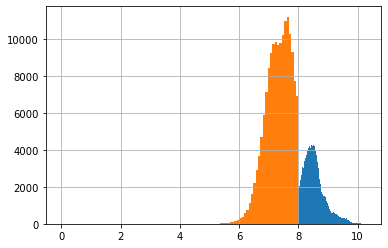

In [10]:
threshold = 8
target[target>threshold].hist(bins=100)
target[target<=threshold].hist(bins=100)

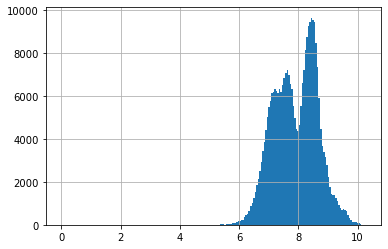

In [14]:
target.hist(bins=200)

In [30]:
train['label'] = 0
train.label.loc[train['target']>threshold] = 1

id
3         1
11        1
13        1
20        1
22        1
         ..
499993    1
499994    1
499997    1
499998    1
499999    1
Name: label, Length: 144878, dtype: int64

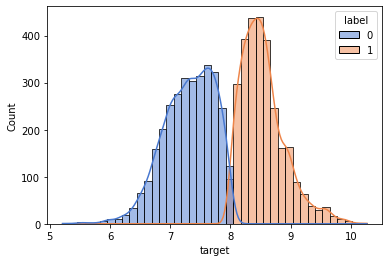

In [33]:
sns.histplot(x='target', data=train[::50], hue='label', palette='muted', kde=True)